DISCLAIMER: Check "model/" folder for the complete code!

# Prerequisites

In [2]:
import sys, os

import torch
import numpy as np

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [3]:
test_number = 4

homework_root_path = '../../'
data_root_path = '../../data/'

data_train_path = os.path.join( data_root_path , 'train.tsv' )
data_dev_path = os.path.join( data_root_path , 'dev.tsv' )

models_classes_path = '../../model/test' + str(test_number) + '/'
models_saves_path = '../../model/test' + str(test_number) + '/saves/'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [5]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Path:

In [6]:
sys.path.append( models_classes_path )

%load_ext autoreload
%autoreload 2

# Global parameters

These parameters are needed in various classes, so they will be saved so to be used in the final model:

In [6]:
globalParams = {
    'PAD_TOKEN': '<pad>',
    'PAD_INDEX': -1,
    'UNK_TOKEN': '<unk>',
    'window_size': 41,
    'window_shift': 41 - 20
}

# Using GloVe as embedding

After the first test done with "test1" and by seeing the results done in "test2", I sticked with GloVe word vector representation. <br>
The padding and the unknown tokens were added at the extracted embedding layer and also at the vocabulary mappings.

In [7]:
import gensim.downloader as gensim_api

embedding_keyedvectors = gensim_api.load('glove-wiki-gigaword-300')

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Observing the space:

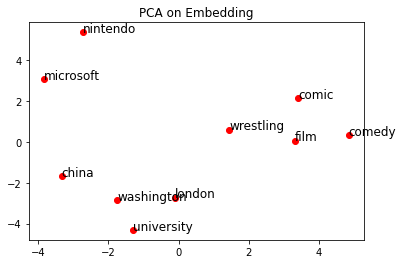

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_some_data():
    # pick some words to visualise
    words = ['film','washington','comedy','university','wrestling','london','china','microsoft','comic','nintendo']
    
    # retrieve the trained embeddings
    coords = [embedding_keyedvectors[word] for word in words]
    

    # perform PCA to reduce our Nd embeddings to 2d points that can be plotted
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(coords) # .t() transpose the embeddings
    
    for i,(x,y) in enumerate(pca_result):
        plt.plot(x, y, 'ro')
        plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
    plt.title('PCA on Embedding')
    plt.show()
    
plot_some_data()

In [9]:
def create_embedding_from_keyedvectors(keyedvectors, freeze = False):
    vectors = keyedvectors.vectors
    padding_idx = vectors.shape[0]
    # pad vector is all zeros
    pad = np.zeros((1, vectors.shape[1]))
    # unk vector is the mean vector
    unk = np.mean(vectors, axis=0, keepdims=True)
    # concatenate
    weights = torch.FloatTensor( np.concatenate((vectors,pad,unk)) )
    return torch.nn.Embedding.from_pretrained(weights, padding_idx=padding_idx, freeze=freeze)

In [10]:
embedding_layer = create_embedding_from_keyedvectors(embedding_keyedvectors, freeze = True)

In [11]:
embedding_layer.num_embeddings, embedding_layer.embedding_dim

(400002, 300)

In [12]:
def create_vocabulary_from_keyedvectors(keyedvectors, globalParams):
    index_to_key = keyedvectors.index_to_key.copy()
    key_to_index = keyedvectors.key_to_index.copy()
    
    index_to_key.append(globalParams['PAD_TOKEN'])
    index_to_key.append(globalParams['UNK_TOKEN'])

    key_to_index[globalParams['PAD_TOKEN']] = len(key_to_index)
    key_to_index[globalParams['UNK_TOKEN']] = len(key_to_index)

    return {'key_to_index':key_to_index, 'index_to_key':index_to_key}

In [13]:
vocabulary = create_vocabulary_from_keyedvectors(embedding_keyedvectors, globalParams)

In [14]:
vocabulary['index_to_key'][-2], vocabulary['index_to_key'][-1]

('<pad>', '<unk>')

In [15]:
vocabulary['key_to_index'][globalParams['PAD_TOKEN']], vocabulary['key_to_index'][globalParams['UNK_TOKEN']]

(400000, 400001)

# POS Tagging

Now we add POS tagging to the vocabulary and into the dataset

In [16]:
globalParams['pos_tagger_name'] = 'en_core_web_sm'

In [17]:
import spacy
pos_tagger = spacy.load(globalParams['pos_tagger_name'])

In [18]:
test_p = ['does', 'anybody', 'really', 'know', 'what', 'time', 'it', 'is?', '(', 'single', 'version', ')', '(', 'lamm', ')', '–', '3', ':', '19']

doc_p = spacy.tokens.Doc(pos_tagger.vocab, words=test_p)
doc_p = pos_tagger( doc_p )

In [19]:
print("Pipeline:", pos_tagger.pipe_names)
processed_sentence = pos_tagger( ' '.join(['John','Lucas','joined','Aiimi','as', 'data','scientist','in','New','York','.']) )
print( [token.pos_ for token in processed_sentence] )

Pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
['PROPN', 'PROPN', 'VERB', 'PROPN', 'ADP', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'PROPN', 'PUNCT']


In [20]:
pos_types = ['ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
print('there are', len(pos_types),'possible POS tags')

there are 19 possible POS tags


adding pad tag

In [21]:
vocabulary_pos = {}

vocabulary_pos['index_to_key'] = [ globalParams['PAD_TOKEN'] ] + pos_types
vocabulary_pos['key_to_index'] = {p:i for i,p in enumerate(vocabulary_pos['index_to_key'])}

print(vocabulary_pos['index_to_key'])
print()
print(vocabulary_pos['key_to_index'])

['<pad>', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']

{'<pad>': 0, 'ADJ': 1, 'ADP': 2, 'ADV': 3, 'AUX': 4, 'CONJ': 5, 'CCONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18, 'SPACE': 19}


# Dataset

The dataset is still the same as in the second test

In [22]:
from NERDataset import NERDataset

In [23]:
dataset_train = NERDataset(data_train_path, vocabulary = vocabulary, params = globalParams, vocabulary_pos = vocabulary_pos, pos_tagger = pos_tagger)
dataset_dev = NERDataset(data_dev_path, vocabulary = None, params = globalParams, vocabulary_pos = vocabulary_pos, pos_tagger = pos_tagger)

In [24]:
print(dataset_train.data[0])

{'inputs': ['it', 'lies', 'approximately', 'north', 'east', 'of', 'bolesławiec', ',', 'and', 'west', 'of', 'the', 'regional', 'capital', 'wrocław', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 'outputs': ['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 'pos': ['PRON', 'VERB', 'ADV', 'PROPN', 'PROPN', 'ADP', 'NOUN', 'PUNCT', 'CCONJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'PUNCT', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']}


Checking how many OOVs are in the training

In [25]:
words_in_train = list(set(word for sample in dataset_train for word in sample['inputs']))
words_not_present = [w for w in words_in_train if w not in vocabulary['key_to_index']]
print( len( words_not_present ) , 'words not present out of' , len(words_in_train))

3399 words not present out of 29966


Saving everything for later

In [26]:
dataset_train.save_labels( os.path.join(models_saves_path,'dataset_labels.npy') )

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [27]:
dataset_train.save_vocabulary( os.path.join(models_saves_path,'dataset_vocabulary.npy') )

In [28]:
dataset_train.save_vocabulary_pos( os.path.join(models_saves_path,'dataset_vocabulary_pos.npy') )

Creating the Dataloader:

In [29]:
BATCH_SIZE = 32
EPOCHS = 16

In [30]:
prepare_batch = NERDataset.prepare_batch_fn(dataset_train.vocabulary, dataset_train.label2id, globalParams['UNK_TOKEN'], vocabulary_pos = vocabulary_pos)

In [31]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=prepare_batch)
dataloader_dev = DataLoader(dataset_dev, batch_size=BATCH_SIZE, shuffle=False, collate_fn=prepare_batch)

In [32]:
for x in dataloader_dev:
    generic_element = x
    break
np.array(generic_element['inputs']).shape # (batch_size, window_size)

(32, 41)

In [33]:
print('Input')
print(generic_element['inputs'][0])
print('Output')
print(generic_element['outputs'][0])
print('Pos')
print(generic_element['pos'][0])

Input
tensor([    13,      0,    122,      3,      0,   3160,    785,   9414,   4606,
           145,   3385, 400001,     69,     38,     40,   1315,   2141,      2,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000])
Output
tensor([12, 12, 12, 12, 12, 12,  4, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1])
Pos
tensor([ 2,  7,  9,  2,  7,  9, 13, 13,  9,  9, 17, 10,  9, 12,  4, 17,  9, 14,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0])


In [34]:
input_size = len(vocabulary['key_to_index']) # how many different words?
input_length_train = max([len(sentence_list['inputs']) for sentence_list in dataset_train]) # maximum length of sentence
input_length_dev = max([len(sentence_list['inputs']) for sentence_list in dataset_dev]) # maximum length of sentence (dev)
n_labels = len(dataset_train.label2id)

print('input_size: ', input_size, '\nmax input_length train: ', input_length_train, '\nmax input_length dev: ', input_length_dev, '\nn_labels: ', n_labels)

input_size:  400002 
max input_length train:  41 
max input_length dev:  41 
n_labels:  13


# Loss and parameters

The model here is changed: POS idea is added!

The loss function if CRF is not used:

In [35]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=globalParams['PAD_INDEX']) # !

These are all the parameters needed to initialize the model:

In [36]:
globalParams['n_labels'] = n_labels
globalParams['use_crf'] = False
globalParams['embedding_word_shape'] = ( embedding_layer.num_embeddings , embedding_layer.embedding_dim )
globalParams['embedding_pos_shape'] = ( len(vocabulary_pos['index_to_key']) , embedding_layer.embedding_dim ) # TODO
globalParams['embedding_word_padding_idx'] = vocabulary['key_to_index'][globalParams['PAD_TOKEN']]
globalParams['embedding_pos_padding_idx'] = vocabulary_pos['key_to_index'][globalParams['PAD_TOKEN']]
globalParams['freeze_word_embedding'] = True
globalParams['freeze_pos_embedding'] = False
globalParams['lstm_parameters'] = {
    'hidden_size':128,
    'bidirectional':True,
    'num_layers':3,
    'dropout':0.35
}
globalParams['general_dropout'] = 0.35


Saving global variables...

In [37]:
np.save(os.path.join(models_saves_path, 'global_params.npy'), globalParams)

In [38]:
globalParams = np.load(os.path.join(models_saves_path, 'global_params.npy'), allow_pickle=True).tolist()
globalParams

{'PAD_TOKEN': '<pad>',
 'PAD_INDEX': -1,
 'UNK_TOKEN': '<unk>',
 'window_size': 41,
 'window_shift': 21,
 'pos_tagger_name': 'en_core_web_sm',
 'n_labels': 13,
 'use_crf': False,
 'embedding_word_shape': (400002, 300),
 'embedding_pos_shape': (20, 300),
 'embedding_word_padding_idx': 400000,
 'embedding_pos_padding_idx': 0,
 'freeze_word_embedding': True,
 'freeze_pos_embedding': False,
 'lstm_parameters': {'hidden_size': 128,
  'bidirectional': True,
  'num_layers': 3,
  'dropout': 0.35},
 'general_dropout': 0.35}

In [39]:
from torchinfo import summary

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

def print_network_structure(model, params_dict, print_summary_extended = True):
    if print_summary_extended:
        s = summary(model, 
                input_data=(generic_element['inputs'], generic_element['pos']), 
                col_names=["kernel_size", "output_size", "num_params"])
        print(s)
    else:
        print_summary(model)

    print('-------- Variables ----------')
    return params_dict

import matplotlib.pyplot as plt

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    plt.plot([i for i in range(len(dict_history['train_history']))], dict_history['train_history'], label='train')
    plt.plot([i for i in range(len(dict_history['valid_loss_history']))], dict_history['valid_loss_history'], label='val_loss')
    plt.plot([i for i in range(len(dict_history['valid_f1_history']))], dict_history['valid_f1_history'], label='val_f1')
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Model without POS

First, I will restart from a simple (but deep) network and then I will add POS in it, to see the differences in performances:

In [197]:
from FinalModel import FinalModel

In [198]:
if 'embedding_layer' not in locals() or embedding_layer is None:
    print('|WARN| embedding_layer NOT INITIALIZED')
    embedding_layer = None

if 'loss_function' not in locals() or loss_function is None:
    print('|WARN| loss_function NOT INITIALIZED')
    loss_function = None

In [8]:
net_no_pos = 'nernet_weights_simple.pth'

In [199]:
# cross-entropy will not be used if there's the crf layer
student = FinalModel(
    models_saves_path, 
    model_save_file_name = net_no_pos,
    load_model = False, 
    custom_embedding_layer = embedding_layer, 
    loss_fn = loss_function
)

Creating final model...
Creating model...
Init done


In [200]:
print_network_structure(student.model, globalParams, True)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
NERNet                                   --                        --                        --
├─Embedding: 1-1                         [300, 400002]             [32, 41, 300]             (120,000,600)
├─Dropout: 1-2                           --                        [32, 41, 300]             --
├─LSTM: 1-3                              --                        [32, 41, 256]             1,230,848
├─CrossEntropyLoss: 1-4                  --                        --                        --
├─Dropout: 1-5                           --                        --                        --
├─ReLU: 1-6                              --                        --                        --
├─Linear: 1-7                            [256, 13]                 [32, 41, 13]              3,341
Total params: 121,234,789
Trainable params: 1,234,189
Non-trainable params: 120,000,600
Total mult-adds (G): 5

{'PAD_TOKEN': '<pad>',
 'PAD_INDEX': -1,
 'UNK_TOKEN': '<unk>',
 'window_size': 41,
 'window_shift': 21,
 'pos_tagger_name': 'en_core_web_sm',
 'n_labels': 13,
 'use_crf': False,
 'embedding_word_shape': (400002, 300),
 'embedding_pos_shape': (20, 300),
 'embedding_word_padding_idx': 400000,
 'embedding_pos_padding_idx': 0,
 'lstm_parameters': {'hidden_size': 128,
  'bidirectional': True,
  'num_layers': 3,
  'dropout': 0.35},
 'general_dropout': 0.35,
 'freeze_word_embedding': True,
 'freeze_pos_embedding': False}

This training function was taken and modified from the notebook #5:

In [40]:
from train_phase import train_and_evaluate

In [47]:
import torch.optim as optim

# optimizer = optim.SGD(student.model.parameters(), lr=0.0016, momentum=0.9)
optimizer = optim.Adam(student.model.parameters(), lr=0.0016)

data_eval_input = []
data_eval_label = []
for sentence in NERDataset.read_dataset(data_dev_path):
    data_eval_input.append(sentence['inputs'])
    data_eval_label.append(sentence['outputs'])

In [204]:
train_model = True

if train_model:

    history = train_and_evaluate(   student, optimizer, dataloader_train, dataloader_dev,
                                    data_eval_input, data_eval_label, epochs=EPOCHS, verbose=True, device=device)

  Epoch   0 => avg_loss: 0.510676
    Validation loss => 0.293090 f1-score => 0.505388
  Epoch   1 => avg_loss: 0.272827
    Validation loss => 0.231718 f1-score => 0.593636
  Epoch   2 => avg_loss: 0.221810
    Validation loss => 0.212329 f1-score => 0.627026
  Epoch   3 => avg_loss: 0.191264
    Validation loss => 0.202113 f1-score => 0.636606
  Epoch   4 => avg_loss: 0.167139
    Validation loss => 0.200732 f1-score => 0.655669
  Epoch   5 => avg_loss: 0.148442
    Validation loss => 0.191777 f1-score => 0.660578
  Epoch   6 => avg_loss: 0.133531
    Validation loss => 0.189336 f1-score => 0.678808
  Epoch   7 => avg_loss: 0.122653
    Validation loss => 0.185181 f1-score => 0.691717
  Epoch   8 => avg_loss: 0.110956
    Validation loss => 0.195498 f1-score => 0.702817
  Epoch   9 => avg_loss: 0.102271
    Validation loss => 0.209236 f1-score => 0.699581
----- Warning stop activated! -----
  Epoch  10 => avg_loss: 0.098090
    Validation loss => 0.202925 f1-score => 0.697348
----- F

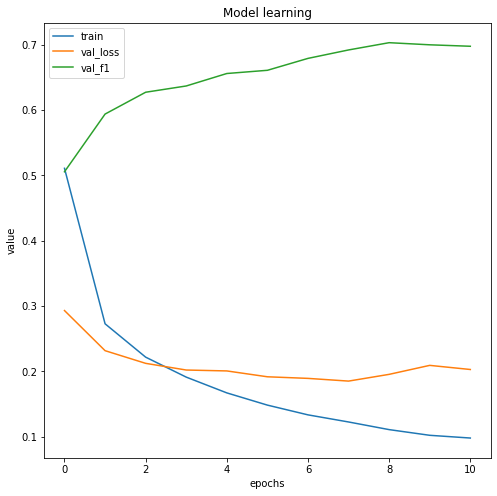

In [205]:
display_history(history)

In [207]:
save_model = True

if save_model:
    student.model.save_weights(os.path.join(models_saves_path,net_no_pos))

# Integrating POS

In [42]:
from FinalModel import FinalModel

In [43]:
globalParams['n_labels'] = n_labels
globalParams['use_crf'] = False
globalParams['embedding_word_shape'] = ( embedding_layer.num_embeddings , embedding_layer.embedding_dim )
globalParams['embedding_pos_shape'] = ( len(vocabulary_pos['index_to_key']) , embedding_layer.embedding_dim ) # TODO
globalParams['embedding_word_padding_idx'] = vocabulary['key_to_index'][globalParams['PAD_TOKEN']]
globalParams['embedding_pos_padding_idx'] = vocabulary_pos['key_to_index'][globalParams['PAD_TOKEN']]
globalParams['freeze_word_embedding'] = True
globalParams['freeze_pos_embedding'] = False
globalParams['lstm_parameters'] = {
    'hidden_size':128,
    'bidirectional':True,
    'num_layers':3,
    'dropout':0.4
}
globalParams['general_dropout'] = 0.3


Saving global variables...

In [44]:
np.save(os.path.join(models_saves_path, 'global_params.npy'), globalParams)

In [45]:
globalParams = np.load(os.path.join(models_saves_path, 'global_params.npy'), allow_pickle=True).tolist()
globalParams

{'PAD_TOKEN': '<pad>',
 'PAD_INDEX': -1,
 'UNK_TOKEN': '<unk>',
 'window_size': 41,
 'window_shift': 21,
 'pos_tagger_name': 'en_core_web_sm',
 'n_labels': 13,
 'use_crf': False,
 'embedding_word_shape': (400002, 300),
 'embedding_pos_shape': (20, 300),
 'embedding_word_padding_idx': 400000,
 'embedding_pos_padding_idx': 0,
 'freeze_word_embedding': True,
 'freeze_pos_embedding': False,
 'lstm_parameters': {'hidden_size': 128,
  'bidirectional': True,
  'num_layers': 3,
  'dropout': 0.4},
 'general_dropout': 0.3}

In [46]:
# cross-entropy will not be used if there's the crf layer
student = FinalModel(
    models_saves_path, 
    model_save_file_name = 'nernet_weights_pos.pth',
    load_model = False, 
    custom_embedding_layer = embedding_layer, 
    loss_fn = loss_function
)

Creating final model...
Creating model...
Init done


In [48]:
import torch.optim as optim

# optimizer = optim.SGD(student.model.parameters(), lr=0.0016, momentum=0.9)
optimizer = optim.Adam(student.model.parameters(), lr=0.0016)

data_eval_input = []
data_eval_label = []
for sentence in NERDataset.read_dataset(data_dev_path):
    data_eval_input.append(sentence['inputs'])
    data_eval_label.append(sentence['outputs'])

In [49]:
print_network_structure(student.model, globalParams, True)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
NERNet                                   --                        --                        --
├─Embedding: 1-1                         [300, 400002]             [32, 41, 300]             (120,000,600)
├─Dropout: 1-2                           --                        [32, 41, 300]             --
├─LSTM: 1-3                              --                        [32, 41, 256]             1,230,848
├─Linear: 1-4                            [128, 64]                 --                        (recursive)
├─Linear: 1-5                            [84, 64]                  --                        (recursive)
├─Linear: 1-6                            [64, 13]                  --                        (recursive)
├─CrossEntropyLoss: 1-7                  --                        --                        --
├─Linear: 1-8                            [256, 128]                [32, 41, 128]      

{'PAD_TOKEN': '<pad>',
 'PAD_INDEX': -1,
 'UNK_TOKEN': '<unk>',
 'window_size': 41,
 'window_shift': 21,
 'pos_tagger_name': 'en_core_web_sm',
 'n_labels': 13,
 'use_crf': False,
 'embedding_word_shape': (400002, 300),
 'embedding_pos_shape': (20, 300),
 'embedding_word_padding_idx': 400000,
 'embedding_pos_padding_idx': 0,
 'freeze_word_embedding': True,
 'freeze_pos_embedding': False,
 'lstm_parameters': {'hidden_size': 128,
  'bidirectional': True,
  'num_layers': 3,
  'dropout': 0.4},
 'general_dropout': 0.3}

In [50]:
train_model = True

if train_model:

    history_pos = train_and_evaluate(   student, optimizer, dataloader_train, dataloader_dev,
                                    data_eval_input, data_eval_label, epochs=EPOCHS, verbose=True, device=device)

  Epoch   0 => avg_loss: 0.803388
    Validation loss => 0.584316 f1-score => 0.064126
  Epoch   1 => avg_loss: 0.506108
    Validation loss => 0.394953 f1-score => 0.202860
  Epoch   2 => avg_loss: 0.385277
    Validation loss => 0.308915 f1-score => 0.423011
  Epoch   3 => avg_loss: 0.311188
    Validation loss => 0.277547 f1-score => 0.527085
  Epoch   4 => avg_loss: 0.267115
    Validation loss => 0.258258 f1-score => 0.584281
  Epoch   5 => avg_loss: 0.235665
    Validation loss => 0.255611 f1-score => 0.603046
  Epoch   6 => avg_loss: 0.213274
    Validation loss => 0.255836 f1-score => 0.611998
  Epoch   7 => avg_loss: 0.192973
    Validation loss => 0.244343 f1-score => 0.621282
  Epoch   8 => avg_loss: 0.178409
    Validation loss => 0.248833 f1-score => 0.638940
  Epoch   9 => avg_loss: 0.168611
    Validation loss => 0.249238 f1-score => 0.638636
----- Warning stop activated! -----
  Epoch  10 => avg_loss: 0.158351
    Validation loss => 0.243383 f1-score => 0.654250
----- W

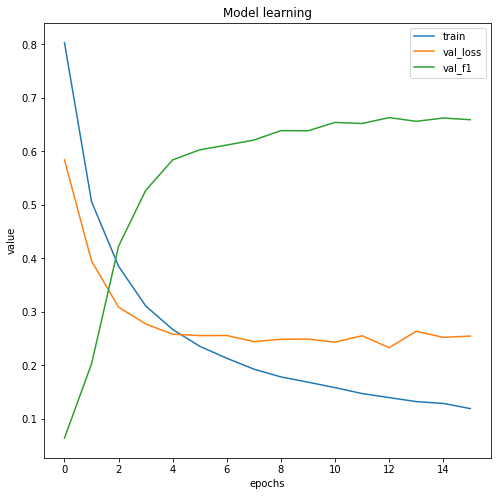

In [51]:
display_history(history_pos)

The resulting model with POS didn't made a significant difference in order to be used. So POS tagging will not be used.

# Evaluating with other metrics... (non-POS model)

In [216]:
def remove_indices_from_lists(y_pred, y_true, black_list):
    '''
    Removes from y_pred and y_true the values contained in black_list that matches with y_true
    '''
    y_pred_refined, y_true_refined = [], []
    for p,l in zip(y_pred, y_true):
        if l not in black_list:
            y_pred_refined.append(p) 
            y_true_refined.append(l)
    return y_pred_refined, y_true_refined

def obtain_pred_labels(model, valid_dataset, device):
    model.to(device)
    model.eval() # dropout to 0

    y_true_total = []
    y_pred_total = []
    
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs'].to(device)
            pos = sample['pos'].to(device)
            y_true = sample['outputs']

            y_pred = model( inputs, pos, mask = ~y_true.eq(-1) )
            if model.crf is None:
                y_pred = model.get_indices(y_pred)
                y_pred = y_pred.view(-1)
                y_true = y_true.view(-1)
            else:
                y_pred = torch.tensor([val for row in y_pred for val in row])
                y_true = torch.tensor([val for row in y_true for val in row if val != -1])

            y_pred_total.append(y_pred)
            y_true_total.append(y_true)

    y_pred, y_true = torch.cat(y_pred_total, dim=0).cpu().numpy(), torch.cat(y_true_total, dim=0).cpu().numpy()
    assert len(y_pred) == len(y_true)
    y_pred, y_true = remove_indices_from_lists(y_pred, y_true, [-1])
    return y_pred, y_true

In [217]:
y_pred, y_true = obtain_pred_labels(student.model, dataloader_dev, device)

In [218]:
from sklearn.metrics import classification_report

print( classification_report(y_true, y_pred, target_names=dataset_train.id2label) )

              precision    recall  f1-score   support

      B-CORP       0.71      0.60      0.65       136
        B-CW       0.67      0.64      0.65       173
       B-GRP       0.80      0.78      0.79       193
       B-LOC       0.83      0.88      0.86       252
       B-PER       0.89      0.88      0.88       315
      B-PROD       0.59      0.59      0.59       157
      I-CORP       0.79      0.61      0.69       121
        I-CW       0.75      0.74      0.75       271
       I-GRP       0.85      0.81      0.83       397
       I-LOC       0.87      0.77      0.81       159
       I-PER       0.90      0.91      0.90       349
      I-PROD       0.67      0.70      0.69        91
           O       0.97      0.98      0.98     11013

    accuracy                           0.94     13627
   macro avg       0.79      0.76      0.77     13627
weighted avg       0.94      0.94      0.94     13627



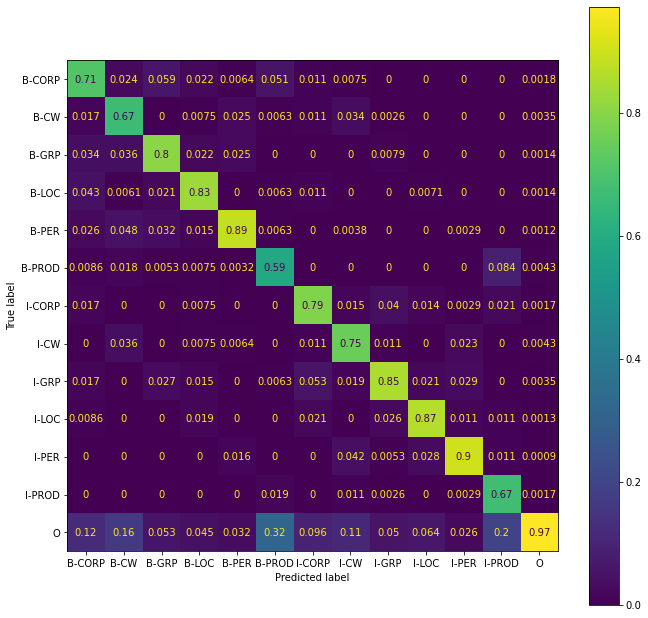

In [219]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='pred') # normalized over predicted label: the sum of each column is 1
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset_train.id2label)
fig, ax = plt.subplots(figsize=(11,11))
cmd.plot(ax=ax)

In [220]:
data_eval_input = []
data_eval_label = []
for sentence in NERDataset.read_dataset(data_dev_path):
    data_eval_input.append(sentence['inputs'])
    data_eval_label.append(sentence['outputs'])

data_eval_predict = student.predict(data_eval_input)

from seqeval.metrics import accuracy_score, f1_score

acc = accuracy_score(data_eval_label, data_eval_predict)
f = f1_score(data_eval_label, data_eval_predict, average="macro")

print(f"# accuracy: {acc:.4f}")
print(f"# f1: {f:.4f}")

# accuracy: 0.9407
# f1: 0.6832


# Testing usability...

In [222]:
y_true_sample = ['B-PER','I-PER','O','B-CORP','O','O','O','O','B-LOC','I-LOC','O']
input_sample = ['John','Lucas','joined','Aiimi','as','data','scientist','in','New','York','.']

print( student.predict([input_sample]) )

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CW', 'I-CW', 'O']]


Testing a long phrase...

In [223]:
long_sample = [ 'childhood', 'friends', 'Bill', 'Gates', 'and', 'Paul', 'Allen', 'sought', 'to', 'make', 'a', 'business', 'using', 'their', 'skills', 'in', 'computer', 
                'programming.', 'in', '1972,', 'they', 'founded', 'traf-o-data,', 'which', 'sold', 'a', 'rudimentary', 'computer', 'to', 'track', 'and', 'analyze', 
                'automobile', 'traffic', 'data', '.', 'gates', 'enrolled', 'at', 'harvard', 'university', 'while', 'allen', 'pursued', 'a', 'degree', 'in', 'computer', 
                'science', 'at', 'washington', 'state', 'university', ',', 'though', 'he', 'later', 'dropped', 'out', 'to', 'work', 'at', 'honeywell', '.', 'the', 'january', 
                '1975', 'issue', 'of', 'popular', 'electronics', 'featured', 'micro', 'instrumentation', 'and', 'telemetry', "systems", '(', 'mits', ')', 'altair', '8800', 'microcomputer']
long_sample_predictions = student.predict([long_sample])
print(len(long_sample), len(long_sample_predictions[0]))
print(list(zip(long_sample,long_sample_predictions[0])))

83 83
[('childhood', 'O'), ('friends', 'O'), ('Bill', 'B-PER'), ('Gates', 'I-PER'), ('and', 'O'), ('Paul', 'B-PER'), ('Allen', 'I-PER'), ('sought', 'O'), ('to', 'O'), ('make', 'O'), ('a', 'O'), ('business', 'O'), ('using', 'O'), ('their', 'O'), ('skills', 'O'), ('in', 'O'), ('computer', 'O'), ('programming.', 'O'), ('in', 'O'), ('1972,', 'O'), ('they', 'O'), ('founded', 'O'), ('traf-o-data,', 'B-CORP'), ('which', 'O'), ('sold', 'O'), ('a', 'O'), ('rudimentary', 'O'), ('computer', 'O'), ('to', 'O'), ('track', 'O'), ('and', 'O'), ('analyze', 'O'), ('automobile', 'O'), ('traffic', 'O'), ('data', 'O'), ('.', 'O'), ('gates', 'O'), ('enrolled', 'O'), ('at', 'O'), ('harvard', 'B-GRP'), ('university', 'I-GRP'), ('while', 'O'), ('allen', 'O'), ('pursued', 'O'), ('a', 'O'), ('degree', 'O'), ('in', 'O'), ('computer', 'O'), ('science', 'O'), ('at', 'O'), ('washington', 'B-GRP'), ('state', 'I-GRP'), ('university', 'I-GRP'), (',', 'O'), ('though', 'O'), ('he', 'O'), ('later', 'O'), ('dropped', 'O'),